In [15]:
import os, sys
import tensorflow as tf
import numpy as np
import time
import subprocess
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

ImportError: cannot import name 'get_enclosing_xla_context' from 'tensorflow.python.ops.control_flow_ops' (C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py)

In [4]:
import tensorflow.keras as keras
print(keras.__version__)
from tensorflow.keras.layers import Flatten, Input, Dense
from tensorflow.keras.layers import Dropout, Conv1D, Activation, MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import roc_curve
from tensorflow.keras import backend as K
#from tensorflow import set_random_seed

ImportError: cannot import name 'LayerNormalization' from 'tensorflow.python.keras.layers.normalization' (C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\layers\normalization\__init__.py)

In [3]:
import sys
print(sys.executable)

C:\Users\user\anaconda3\python.exe


In [11]:
 tf.__version__

NameError: name 'tf' is not defined

In [5]:
pip list | grep scikit-learn

Note: you may need to restart the kernel to use updated packages.


'grep'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [6]:
#load datasets
def get_datasets(diseases, nr_inputs=260):
    datasets = []
    sample_dir = "datasets/samples"
    for idx, disease in enumerate(diseases):
        dataset_dir = os.path.join(sample_dir, str(idx))
        datasets.append([])
        for record in sorted(os.listdir(dataset_dir)):
            #listdir: 디렉토리 내 모든 파일명 반환
            record_path = os.path.join(dataset_dir, record)
            with open(record_path) as dis:
                dataset = np.loadtxt(dis)
                if len(dataset) != nr_inputs:
                    print(len(dataset), nr_inputs)
                    continue
                datasets[idx].append(dataset)
                #datasets의 크기: 5* 각자 파일 개수 합 
    return datasets

In [7]:
#모든 데이터들을 표준화
def normalize_data(datasets):
    normalized=[]
    for case in datasets: 
        cases=[]
        for data in case:
            mu = np.mean(data) # 평균
            sigma = np.std(data) #분산 
            #fixed = (np.array(data) - mu) / sigma
            fixed = stats.zscore(data)
            cases.append(fixed)
        normalized.append(cases) 
    return normalized

In [8]:
def generate_data(data):
    #np.random.uniform : 균등분포에서 난수 생성
    s_thd = np.random.uniform(low=0.10, high=0.18, size=None)
    m_thd = np.random.uniform(low=-0.2, high=0.2, size=None)
    mu, sigma = np.mean(data), np.std(data)
    noise = np.random.normal(mu, sigma, [data.shape[0],]) * s_thd + m_thd
    fixed = data + noise
    return fixed

In [9]:
#datasets : 표준화된 datasets, data_length idx별 데이터 크기
def generate_datasets(datasets, data_length):
    generate_data_num = [max(data_length) - x for x in data_length]
    for idx, num in enumerate(generate_data_num):
        #idx : 5, num : data_length 최댓값 - data_length[idx]
        for i in range(num):
            target_idx = np.random.randint(data_length[idx], size=None)
            target_data = datasets[idx][target_idx]
            datasets[idx].append(generate_data(target_data).tolist())
            #tolist(): 다른 줄에 있는 같은 index 값을 묶어줌
    return datasets

#길이가 다른 idx 별 data들을 max 크기대로 맞춰줌

In [10]:
#train_data와 valid_data를 9:1로 나눔
def split_train_valid(datasets, split=0.9):
    data_length = [len(x) for x in datasets]
    train_length = int(min(data_length) * split)
    train_data = [x[:train_length] for x in datasets]
    valid_data = [x[train_length:] for x in datasets]
    return train_data, valid_data

In [11]:
def get_label(data):
    label= [[idx]*len(x) for idx, x in enumerate(data)]
    label= label[0]+label[1]+label[2]+label[3]+label[4]+label[5]+label[6]+label[7]+label[8]+label[9]+label[10]+label[11]+label[12]+label[13]+label[14]
    return label

In [12]:
def get_cnn_model(filter_num,filter_size, num_classes=15, 
                  activation='relu', maxpool_size=2, dim=260):
    
    cnn_model = Sequential()
    cnn_model.add(Conv1D (kernel_size=filter_size,
                          filters=filter_num, 
                          input_shape=(dim,1)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
   
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))

    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))

    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    cnn_model.add(Dropout(0.15))
    
    cnn_model.add(Flatten())
    cnn_model.add(Dense(30))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(Dense(20))
    cnn_model.add(Activation(activation))
    cnn_model.add(Dense(num_classes))
    cnn_model.add(Activation('softmax'))
    
    return cnn_model

In [13]:
def fit_model(model, x_train, y_train, x_test, y_test, opt, 
             batch_size=128, epochs=30, shuffle=True,
             loss='categorical_crossentropy',
             metrics=['accuracy'], verbose=0):
    
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=shuffle,
                       verbose=verbose)
    # verbose: 학습할 때 보여지는 정보 조정
    # shuffle: overfitting 을 방지하기 위해 데이터 셋 shuffle
    return history

In [14]:
def get_predict_numpy(model, datasets):
    rs = model.predict(datasets)
    return rs

In [15]:
def get_total_num(y_true, y_pred, label_num):
    total_nums=[]
    for a in range(label_num):
        nums=[]
        idx = np.array(y_true) == a
        for case in range(label_num):
            nums.append(sum(np.array(y_pred)[idx]==case))
        total_nums.append(nums)
    return total_nums

In [16]:
#K.tensorflow_backend._get_available_gpus()

In [17]:
np.random.seed(0)#np
tf.random.set_seed(2) # set_random_seed(2) #tf
#재시작할 때 같은 난수가 발생되도록 seed 설정

### 수정
heart_diseases = ['N','R','L','e','j','A','a','J','S','V','E','F','/','f','Q']
num_classes=15

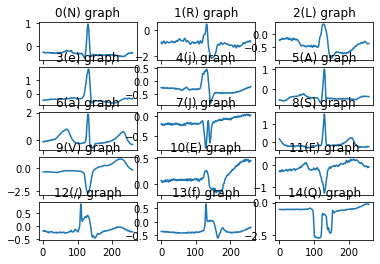

In [40]:
datasets = get_datasets(heart_diseases)

for i in range(15):
    plt.subplot(5,3,i+1)
    plt.title("{}({}) graph".format(i,heart_diseases[i]))
    plt.plot(datasets[i][0])

In [18]:
datasets = get_datasets(heart_diseases) #dataset을 directory에서 가져옴
print(np.shape(x for x in datasets))
#print(datasets[0][0])
datasets = normalize_data(datasets) #dataset을 표준화 
#datasets = [x[:10000] for x in datasets]
data_length = [len(x) for x in datasets] 
print(data_length) 
# >> [34504, 2199, 6987, 802, 3215]
datasets = generate_datasets(datasets, data_length)# data_length 중 최댓값을 기준으로 데이터 갯수 맞춤
generated_data_length = [len(x) for x in datasets]
print(generated_data_length)
#>> [34504, 34504, 34504, 34504, 34504]

()
[29620, 3682, 3200, 16, 229, 1964, 150, 83, 2, 6881, 106, 802, 3200, 982, 33]
[29620, 29620, 29620, 29620, 29620, 29620, 29620, 29620, 29620, 29620, 29620, 29620, 29620, 29620, 29620]


In [19]:
train_data = datasets
print(len(train_data))
train_label = get_label(train_data)
print(np.shape(train_data))
train_data = [x for case in train_data for x in case]
train_data = np.reshape(train_data, (len(train_data), 260, 1))
print(np.shape(train_data))
print(len(train_label))

15
(15, 29620, 260)
(444300, 260, 1)
444300


In [20]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    train_label,
                                                    train_size=0.8)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#to_categorical: one-hot 인코딩 시켜주는 함수

In [21]:
valid_data = datasets
valid_label = get_label(valid_data)
valid_label = keras.utils.to_categorical(valid_label, num_classes)

In [22]:
#test case of filter size
filter_size=[4,8,16]
#filter_size=[4,12]


#test case of filter num
filter_num=[4,8,12,16]
#filter_num=[32]


#test epochs
epochs=30
#learning rate
lr=0.005
#optimizer
opt = keras.optimizers.Adam(lr=lr)
#batch-size
batch_size = 2048#fix value if appear memory error

#history
rs_history_target=[]
#model
rs_model_target=[]
#pred
rs_pred_target=[]
#report
rs_report_target=[]

for size in filter_size:
    for num in filter_num:
        print("======================================================")
        
    #with K.tensorflow_backend.tf.device('/gpu:0'):
        ##############################
        #get cnn model
        model = get_cnn_model(filter_num=num ,filter_size=size)
        print('[filter num]{}  [filter size]{}'.format(num,size))
        print("------------------------------------------------------")

        ##############################
        #compile and fit model
        print(">>fitting model..")

        history = fit_model(model=model, 
                            x_train=x_train,
                            y_train=y_train,
                            x_test=x_test,
                            y_test=y_test,
                            opt=opt,
                            epochs=epochs,
                            verbose=0,
                            batch_size=batch_size
                            )
            
        print(">>fitting complete")
            
        ##############################
        #predict label
        print(">>predict model..")
        predict_list = get_predict_numpy(model, x_test)
        print(">>predict complete")
        
        ##############################
        #data evaluation score
        #label/list | precision | recall | f1-score | support
        #       0 |       
        #       1 |
        #       2 |               score                 num
        #       3 |
        #       4 |  
        print()
        print("[scores]")
        
        flatten_true=[np.argmax(x) for x in y_test]
        flatten_predict=[np.argmax(x) for x in predict_list]
        
        report = classification_report(flatten_true, 
                                    flatten_predict,
                                    target_names=heart_diseases, 
                                    digits=4,
                                    output_dict=True)
        
  ##############################
        #label/pred | 0 | 1 | 2 | 3 | 4 |
        #  0 |                          => sum()=datasets num
        #  1 |                          => sum()=datasets num
        #  2 |         data num         => sum()=datasets num
        #  3 |                          => sum()=datasets num
        #  4 |                          => sum()=datasets num
        ##############################
        r_nums = get_total_num(y_true=flatten_true,
                              y_pred=flatten_predict,
                              label_num=len(heart_diseases))
        print()
        print('[row:label | col:prediction]')
        for r in r_nums:
            print(r)
        

        
        ##############################
        #save result
        ##############################
        print()
        print('[save result]')
        rs_history_target.append(history)
        rs_model_target.append(model)
        rs_pred_target.append(flatten_predict)
        rs_report_target.append(report)
        
        
        print("======================================================")
        print("\n")

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


[filter num]4  [filter size]4
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]

[row:label | col:prediction]
[5757, 18, 7, 0, 5, 33, 26, 4, 1, 26, 14, 5, 1, 3, 9]
[5, 5794, 2, 2, 1, 26, 2, 102, 0, 10, 0, 2, 1, 0, 1]
[8, 1, 5773, 1, 2, 10, 8, 1, 0, 30, 0, 7, 1, 3, 15]
[1, 0, 0, 6104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 8, 0, 7, 5819, 50, 1, 91, 11, 0, 0, 1, 0, 2, 0]
[96, 66, 17, 43, 75, 5451, 78, 28, 6, 46, 0, 21, 0, 5, 9]
[1, 0, 0, 0, 0, 3, 5853, 0, 0, 1, 0, 0, 0, 0, 0]
[10, 33, 0, 29, 0, 2, 0, 5826, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 5858, 0, 0, 0, 0, 0, 0]
[34, 15, 57, 2, 0, 64, 145, 0, 0, 5494, 9, 132, 3, 3, 8]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5935, 0, 0, 0, 0]
[54, 10, 13, 11, 17, 60, 18, 15, 0, 168, 10, 5429, 0, 2, 3]
[0, 0, 0, 0, 0, 0, 2, 0, 0, 15, 0, 0, 5890, 11, 12]
[13, 13, 5, 71, 15, 22, 0, 69, 0, 13, 0, 2, 57, 5640, 34]
[0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5862]

[save 

[filter num]4  [filter size]16
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]

[row:label | col:prediction]
[3980, 27, 66, 6, 61, 518, 226, 23, 0, 129, 2, 739, 0, 114, 18]
[34, 5550, 4, 1, 6, 16, 40, 0, 0, 7, 0, 49, 8, 231, 2]
[5, 0, 5618, 0, 14, 1, 36, 0, 0, 67, 8, 19, 1, 22, 69]
[270, 0, 0, 5263, 0, 309, 0, 0, 0, 200, 0, 20, 0, 43, 0]
[341, 77, 71, 0, 5340, 66, 34, 4, 0, 0, 0, 8, 0, 55, 0]
[506, 713, 171, 26, 297, 3902, 136, 5, 0, 48, 1, 84, 1, 42, 9]
[26, 16, 4, 2, 0, 1, 5589, 30, 0, 75, 12, 23, 0, 30, 50]
[69, 1550, 0, 0, 125, 0, 6, 3534, 0, 4, 0, 583, 0, 29, 0]
[462, 0, 0, 0, 30, 0, 0, 0, 5366, 0, 0, 0, 0, 0, 0]
[36, 15, 120, 2, 0, 8, 238, 17, 0, 4868, 332, 196, 2, 32, 100]
[0, 0, 9, 0, 0, 0, 4, 0, 0, 6, 5905, 0, 3, 3, 8]
[101, 10, 35, 0, 0, 5, 39, 0, 0, 297, 31, 5217, 2, 58, 15]
[5, 1, 54, 0, 4, 0, 11, 0, 2, 52, 1, 0, 5582, 208, 10]
[42, 3, 110, 4, 20, 5, 18, 0, 0, 30, 0, 42, 44, 5571, 65]

[acc][size : 4][num : 4]:0.9519862532615662
[acc][size : 4][num : 8]:0.9807196855545044
[acc][size : 4][num : 12]:0.9882652759552002
[acc][size : 4][num : 16]:0.9922124743461609


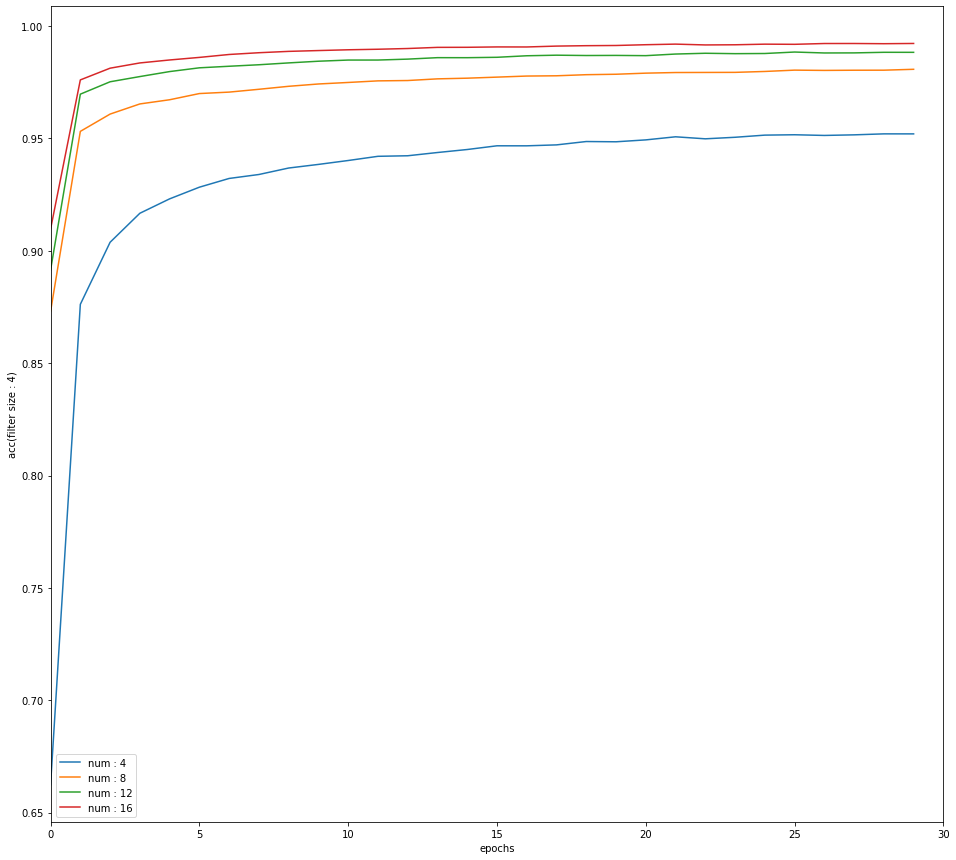

[acc][size : 8][num : 4]:0.9347710013389587
[acc][size : 8][num : 8]:0.9805986881256104
[acc][size : 8][num : 12]:0.989626944065094
[acc][size : 8][num : 16]:0.9933153390884399


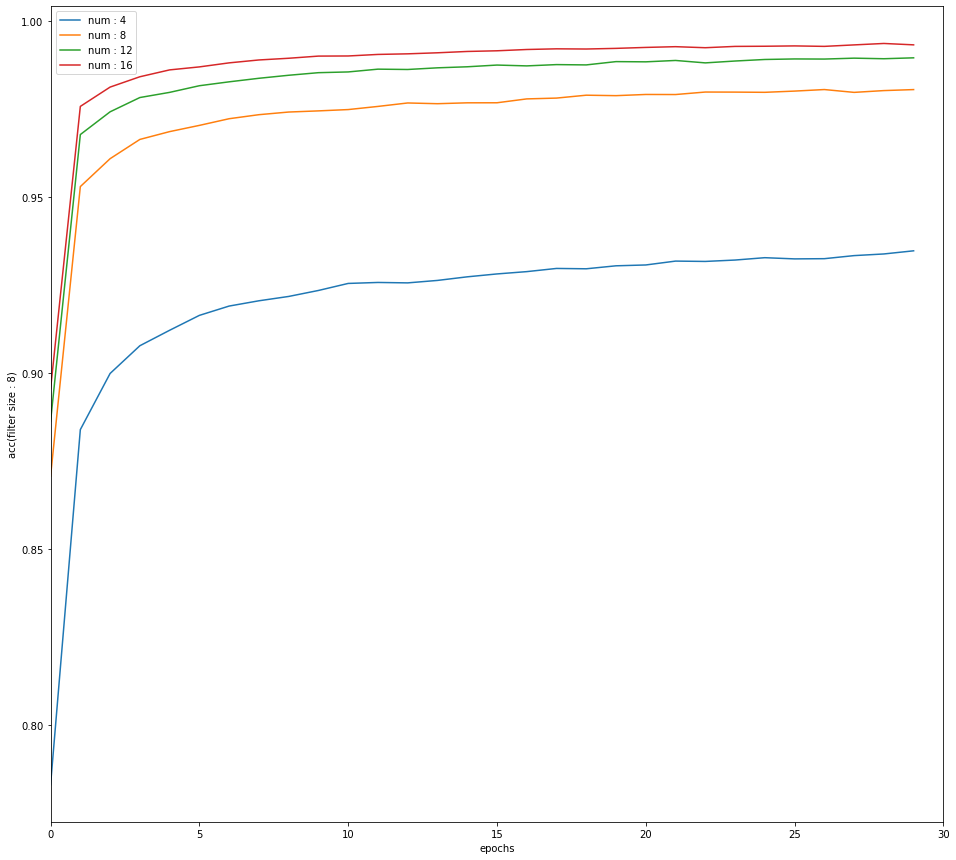

[acc][size : 16][num : 4]:0.8803961277008057
[acc][size : 16][num : 8]:0.9705913662910461
[acc][size : 16][num : 12]:0.9851395487785339
[acc][size : 16][num : 16]:0.991618812084198


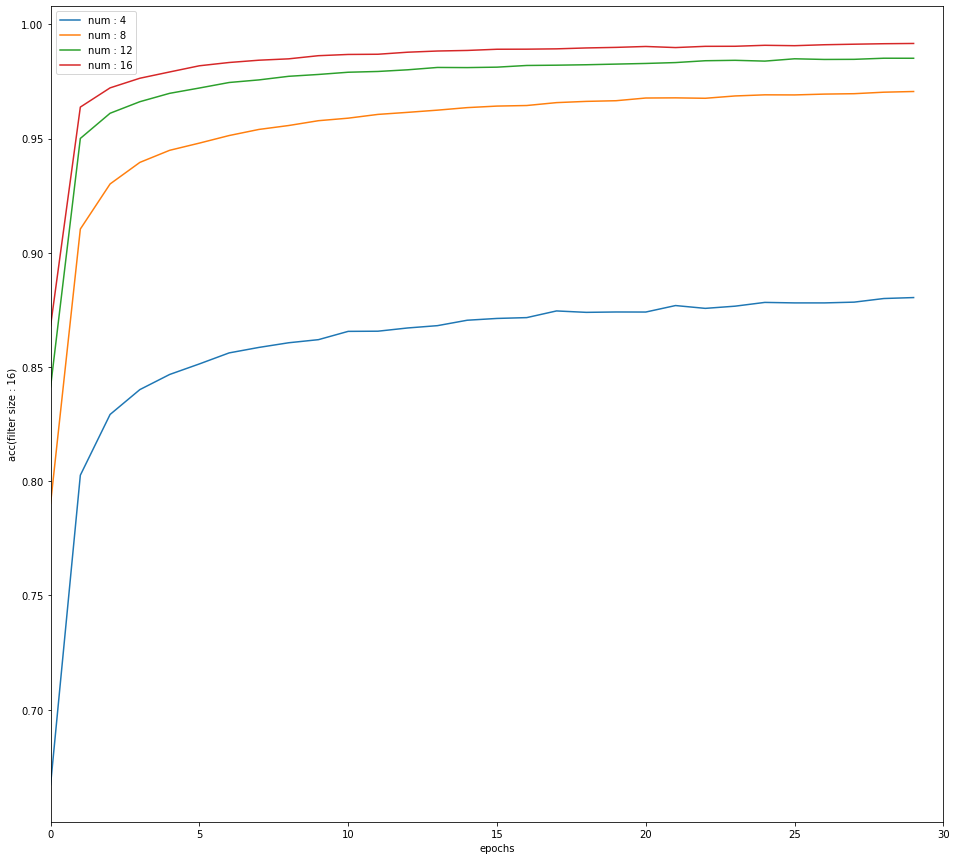

In [24]:
#acc graph 
#graph with each filter size to compare with filter num
for size in range(len(filter_size)):
    plt.figure(figsize=(16,15))
    for num in range(len(filter_num)):
        plt.plot(rs_history_target[size*len(filter_num)+num].history['accuracy'], 
                 label="num : {}".format(filter_num[num]))
        plt.xlim((0, epochs))
        plt.legend()
        plt.xlabel('epochs')
        plt.ylabel('acc(filter size : {})'.format(filter_size[size]))
        print('[acc][size : {}][num : {}]:{}'.format(
            filter_size[size],
            filter_num[num],
            rs_history_target[size*len(filter_num)+num].history['accuracy'][-1] ))
    plt.show()

KeyError: 'micro avg'

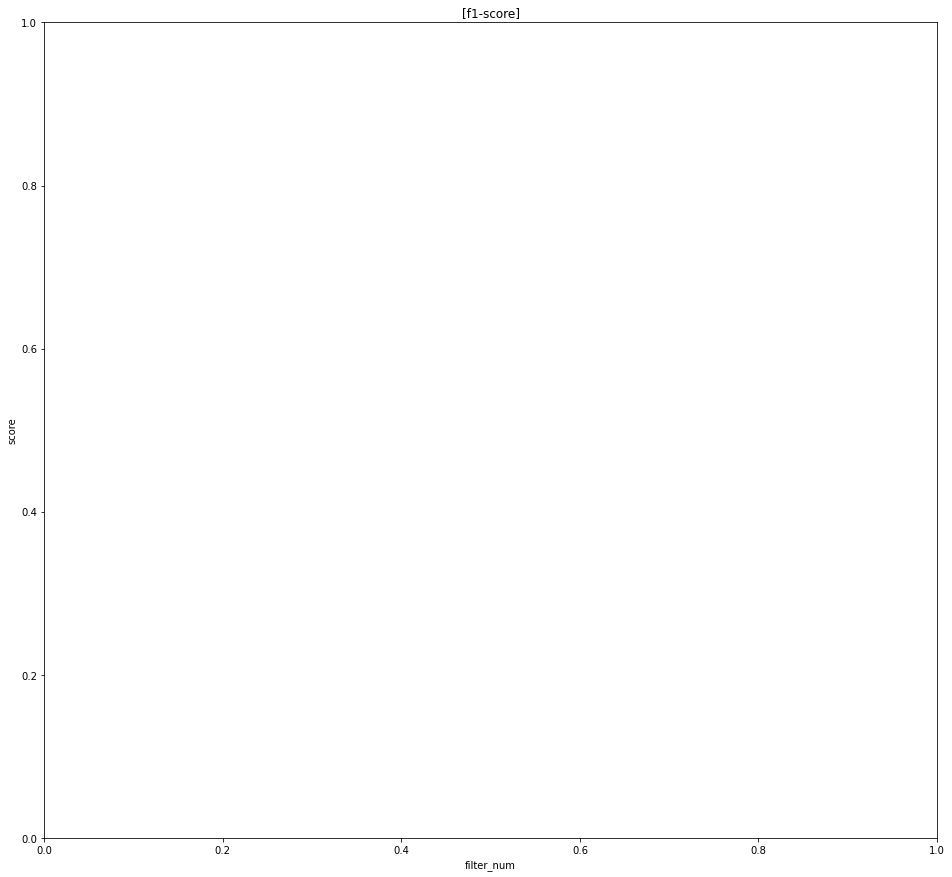

In [26]:
#recall(sen), precision(ppv), f1-score
#graph with each filter size to compare with filter num
legend = ['filter_size : {}'.format(x) for x in filter_size]
#for colkey in ['recall', 'precision', 'f1-score']:
for colkey in ['f1-score']:
    plt.figure(figsize=(16,15))
    for size in range(len(filter_size)):  
        y = []
        plt.title("[{}]".format(colkey))
        plt.xlabel('filter_num')
        plt.ylabel('score') 
        for num in range(len(filter_num)):
            #macro avg : average
            #micro avg : weighted average
            y.append(rs_report_target[size*len(filter_num)+num]['micro avg'][colkey])
        plt.plot([str(x) for x in filter_num],y,'o-')
    plt.legend(legend)
    plt.show()

In [ ]:
#print score values
idx=0
f1_score_mean = [0.] * len(rs_model)
sen_score_mean = [0.] * len(rs_model)
ppv_score_mean = [0.] * len(rs_model)

print_cols = ['support', 'recall', 'precision', 'f1-score']
for size in filter_size:
    for num in filter_num:
        print("[*]size : {}  /  num : {}".format(size, num))
        data = rs_report[idx]
        print("{0:<5}".format(""), end='')
        for col in print_cols:
             print("{0:<17}".format(col), end='')
        print()
        print("----------------------------------------------------------------")
        for key in heart_diseases:
            print("{0:<5}".format(key), end='')
            for val in print_cols:
                print("{0:<15.4f}".format(round(data[key][val],4)), 
                                                         end='  ')
            print()
            f1_score_mean[idx] += data[key]['f1-score']
            sen_score_mean[idx] += data[key]['recall']
            ppv_score_mean[idx] += data[key]['precision']
        print("\n")
        idx+=1

### plot multi classification roc curve

https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/


### calulate acc, spec ..

https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

In [ ]:
def normal(data):
    maxval = max(data)
    minval = min(data)
    data = [(x-minval)/(maxval-minval) for x in data]
    return data

model_params = [model.count_params() for model in rs_model]
plt.title('Compare f1 score & total params')
plt.plot(normal(f1_score_mean), label='score')
plt.plot(normal(model_params), label='num params')
plt.legend()
plt.show()


sorted_f1_score = np.argsort(f1_score_mean)[::-1]
print("[*]Order by f1 score(Model Index):\n{}".format(sorted_f1_score))
sorted_params = np.argsort(model_params)[::-1]
print("[*]Order by model params(Mdel Index):\n{}".format(sorted_params))

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

#test model
idx=sorted_f1_score[0]
# Plot linewidth.
lw = 2
#get label
tty = np.array(y_test)
ttp = np.array(rs_pred[idx])

n_values = np.max(ttp) + 1
y_score =  np.eye(n_values)[ttp]

#plot roc curve
n_classes=len(heart_diseases)
fpr = [None] * len(heart_diseases)
tpr = [None] * len(heart_diseases)
thr = [None] * len(heart_diseases)
roc_auc=[None] * len(heart_diseases)

#endx=1.0
#endy=1.0
endx=0.02#zoom
starty=0.80#zoom

###plot roc 0 ~ 1 range
# heart_diseases = ['N','R','L','e','j','A','a','J','S','V','E','F','/','f','Q']
for i in range(len(heart_diseases)):
    fpr[i], tpr[i], thr[i] = roc_curve(tty[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], 
             label="class {}(area={})".format(i,round(roc_auc[i],4)))
    
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim(0.0,endx)
plt.ylim(starty,1.0)
plt.legend()
plt.show()

# Result

1. 1st important thing total number of params
2. 2nd important thing is number of kernels
3. 3rd important thing is balance between number of kernels of size of kernels